# Redes Neuronales
## Trabajo Práctico N° 1 - Ejercicio 1
* Kammann, Lucas Agustín
* Gaytan, Joaquín Oscar

### Consultas y/o dudas
* Métricas del modelo (Matriz de confusión, exactitud, precisión, etc.)
* Procesamiento de los datos? (Filtrado)
* CountVectorizer, es necesario que lo hagamos a mano o podemos utilizar la librería de sci-kit-learn?
* Filtrado de numeros
* Filtrado de palabras

### Step by step
* Obtención del dataset (separando entre "train" y "test")
* Preprocesamiento de los datos
* Distribuciones condicionales (Verosimilitudes/Likelihood)
* Smoothing
* Probabilidad a Priori
* Clasificación (Naive Bayes Multinomial)
* Clasificación usando log posteriori
* Métricas

# Descripción del problema
Se desea armar un clasificador de correos electrónicos o noticias en función del tópico sobre el cual trata dicho correo electrónico o noticia, para ello, se modela el problema considerando una variable aleatoria discreta $X$ con distribución categórica de $k_x = 20$ categorías, siendo estas los tópicos posibles que pueden tratar los documentos clasificados.

$$X \sim Categorica(p_1, p_2, ..., p_{k_x})$$

Las características a analizar de los documentos para la clasificación, son las palabras. Se asume que el orden de las palabras no importa, que son independientes entre sí y que se encuentran identicamente distribuídas. De esta forma, se define una segunda variable aleatoria discreta $Y$ con distribución categórica de $k_y$ categorías, siendo estas las posibles palabras de nuestro vocabulario.

$$Y \sim Categorica(p_1, p_2, ..., p_{k_y})$$

# Preparación de la base de datos
Usamos la librería **sklearn** para descargar la base de datos de entrenamiento y de validación, ya que se encontraba disponible en sus datasets.

In [4]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

# Loading the datasets
train = fetch_20newsgroups(subset='train', shuffle=True)
test = fetch_20newsgroups(subset='test', shuffle=True)

# Categories
categories = train.target_names

# Train dataset, casting to numpy array
train_raw_input = np.array(train.data)
train_output = np.array(train.target)
train_size = len(train_raw_input)

# Test dataset, casting to numpy array
test_raw_input = np.array(test.data)
test_output = np.array(test.target)
test_size = len(test_raw_input)

# Logging useful information
print(f'Dataset Train: {train_size} elements')
print(f'Dataset Test: {test_size} elements')

Dataset Train: 11314 elements
Dataset Test: 7532 elements


# Explorando la base de datos

## Observando un correo electrónico de forma aleatoria
Buscamos de forma aleatoria un elemento dentro de la base de datos de entrenamiento, con el objetivo de visualizar cómo suelen ser los correos electrónicos de noticias que se poseen, para tener una mejor comprensión de qué podemos llegar a encontrarnos dentro del vocabulario o el documento a analizar.

In [5]:
random_data = np.random.choice(train_raw_input)
print(random_data)

From: dbak@elm.lle.rochester.edu (Douglas Baker)
Subject: Performance of new Mustangs !!!!!!!!!!!!!!!!!!!!!
Article-I.D.: galileo.1993Apr6.170901.7684
Organization: University of Rochester, Rochester NY
Lines: 9
Nntp-Posting-Host: elm.lle.rochester.edu


	Does anyone know the performance ratings for a 1992 or 1993
5.0 L HO Mustang LX like the 0-60 time 1/4 mile and top end ???
Also can you tell me which magazine where these #'s come from so I
can look them up if possable ????  If you could the year and month and
eveen page # if you have it.

						Thanks,
						Doug



## Categorías
Dentro de la base de datos, los correos electrónicos que podemos encontrar pueden tratar de diferentes tópicos, y estos tópicos son las categorías de la variable aleatoria definida $X$.

In [6]:
import pprint

# Show the news categories
pprint.pprint(categories)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


# Histograma de tópicos
Se calcula y grafica el histograma de los tópicos de las noticias o correos electrónicos utilizando la librería **matplotlib**. Del resultado obtenido, se pueden hacer algunos comentarios,
* A simple vista, la distribución es relativamente cercana a una distribución uniforme
* El clasificador trivial tendría una exactitud de aproximadamente 0,05

# TODO! Más lindo el grafico

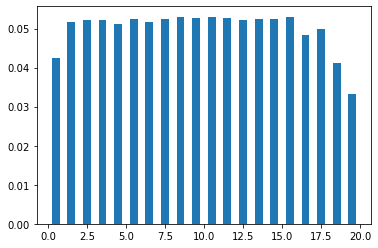

Wall time: 8.73 s


In [7]:
%%time
from matplotlib import pyplot as plt

# Histogram for the categories in the training set
priori, _, _ = plt.hist(train_output, bins=len(categories), range=(0,len(categories)), rwidth=0.5, density=True)
plt.show()

In [8]:
print(f'Shape of the priori probability distribution: {priori.shape}')

Shape of the priori probability distribution: (20,)


# Estimación de probabilidades a priori
Se computan las probabilidades a priori para las categorías, es decir, los tópicos. Se emplea una herramienta distinta a **matplotlib** para comparar el tiempo utilizada en el procesamiento. Se está estimando la siguiente función masa de probabilidad,
$$P(X=x) ; x = 0, 1, ..., 19$$

Para ello, se emplea como estimador la proporción de cada categoría dentro del conjunto de entrenamiento.

In [10]:
%%time

# For each category, filter the amount of occurences in the training dataset
# the compute the priori probability
priori_distribution = np.zeros(len(categories))
for index, category in enumerate(categories):
    frequency = (train_output == index).sum()
    priori_distribution[index] = frequency
priori_distribution /= priori_distribution.sum()

Wall time: 1.99 ms


# Preprocesamiento

Para trabajar con multinomial naive bayes es necesario poder modelar las características de entrada de forma numérica, para ello se definió una variable aleatoria categórica que corresponde a las palabras. Así, asumiendo que el orden de las palabras dentro de un texto no importa, y considerando que las palabras son independientes e igualmente distribuídas, para encontrar dicha distribución es necesario realizar un mapeo de las palabras con los valores numéricos de una variable y luego estimar dicha distribución.

## Tokenización
El proceso de tokenización implica tomar el texto e identificar todas las palabras distintas que se encuentran en el mismo y luego contar la cantidad de ocurrencias que tienen, es decir, cuál es la frecuencia absoluta de las palabras dentro de un texto.

In [68]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Importing and testing the CountVectorizer class of sklearn
vectorizer = TfidfVectorizer(min_df=5, strip_accents='ascii', stop_words='english', encoding='latin1')
train_input = vectorizer.fit_transform(train_raw_input)

Wall time: 7.4 s


In [105]:
import pandas as pd
pd.DataFrame(train_input.toarray(), columns=vectorizer.get_feature_names())

,00,000,0000,0000000004,0001,000152,0002,0005,0005111312,00072,...,zuma,zumabot,zur,zurich,zv,zw,zx,zy,zyeh,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
print(train_input.shape)

(11314, 25636)


# Estimación de distribución de probabilidad condicional

# TODO! Estimación

## Overfitting
El **overfitting** es un problema que ocurre cuando el modelo utilizado no es capaz de predecir correctamente frente a datos nuevos que no se encontraban en el conjunto de entrenamiento, lo cual le quita capacidad de generalizar, un aspecto fundamental en la resolución de problemas de inteligencia artificial. En este caso, para resolver el problema descripto se propone emplear un clasificador naive bayes multinomial, que puede traer apareado un problema de overfitting que se ilustra a continuación.

Sea un texto compuesto por $N$ palabras, para clasificarlo se busca la máxima probabilidad a posteriori, es decir aquella categoría $y$ para la cual la probabilidad de que ese texto pertenezca sea máxima a comparación de otras categorías,

$$P(y|x_1,...,x_N)=\frac{P(x_1,...,x_N|y) \cdot P(y)}{P(x_1,...,x_N)}$$

Aplicando naive bayes, se asumen que las palabras son independientes y luego se añade que sean idénticamente distruidas según el tipo de problema que nos proponemos resolver, entonces

$$P(y|x_1,...,x_N)=\frac{P(x_1|y) \cdot ... \cdot P(x_N|y) \cdot P(y)}{P(x_1,...,x_N)}$$

En función de cómo se estima la distribución de probabilidades, una palabra $x_1$ que no apareció en una categoría durante el entrenamiento fue ponderada con una probabilidad nula, lo cual hace que todo el producto se anule, y si la probabilidad fuera muy grande, por culpa de esta única palabra toda la probabilidad a posteriori se anula llevando a una predicción errónea. Para solucionar esto, se propone emplear el método de Laplacian Smoothing.

## Laplacian Smoothing
El método de Laplacian Smoothing consiste en agregar un cierto conocimiento a priori dentro de la distribución estimada, de forma tal que cuando no se posee demasiada evidencia durante el entrenamiento, la información aportada por tal conocimiento a priori nos permite evitar caer en el escenario de las probabilidades nulas.

El procedimiento consiste en fijar el valor de un **hiperparámetro** $\alpha$, que se suma como cantidad de ocurrencias a cada palabra durante el análisis de frecuencias absolutas en la etapa de estimación. Así, se introduce un conocimiento a priori de cantidad de ocurrencias igual para todas las palabras, es decir, estamos diciendo que sin información supondríamos que la distribución es uniforme. Por lo general, la magnitud de este parámetro define qué tanta información de entrenamiento se necesita para que deje de valer dicho conocimiento a priori.

### Discusiones sobre Laplacian Smoothing
* https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece
* https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf
* https://stats.stackexchange.com/questions/108797/in-naive-bayes-why-bother-with-laplace-smoothing-when-we-have-unknown-words-in
* https://courses.cs.washington.edu/courses/cse446/20wi/Section7/naive-bayes.pdf

In [106]:
%%time

# Separate the matrix of documents (mails) and occurrences of words for each category
# and compute the normalized distribution to get the likelihood for each category
alpha = 0.01
categories_distribution = np.zeros((len(categories), len(vectorizer.vocabulary_.keys())), dtype=np.longdouble)
for index, category in enumerate(categories):
  category_matrix = train_input[train_output == index][:]
  distribution = category_matrix.sum(axis=0) + alpha
  categories_distribution[index,:] = distribution / distribution.sum()

Wall time: 52.9 ms


In [107]:
print(categories_distribution.shape)

(20, 25636)


# Clasificación por máximo a posteriori
El criterio del clasificador de naive bayes consiste en el máximo a posteriori, es decir, buscamos la categoria que maximiza la probabilidad de que sea esa categoría dada la información de las características que recibimos.

Es importante notar que, en la expresión del máximo a posteriori, la probabilidad total de que ocurran conjuntamente las características, es un término invariante para cada categoría. Esto implica, que a los fines de comparar cuál es mayor, sin importar cuánto sea numéricamente esa probabilidad a posteriori, ese término es redundante. Es por esto que fue removido para reducir la carga computacional del algoritmo.

# TODO! Explicar la cuenta desde la potencia de las palabras

### Problema numérico
Si el preprocesamiento no se vuelve lo suficientemente estricto y no limita el vocabulario, la cantidad de palabras provoca que los valores numéricos obtenidos en la verosimilitud sean demasiado chicos y empiezan a darse errores numéricos por la precisión del punto flotante empleado por NumPy.

Este problema se encontró comparando este modelo con el de log probabilidades, y se pudo observar que si se escala la distribución (no se la normaliza), entonces el problema numérico desaparece.

In [115]:
%%time

# Taking a subset of the testing set, to avoid using the complete set
# when the algorithm is too slow... remember this is not strictly the test
# or validation of the model, we are doing only an analysis and it is not required
# for us in this instance to use the complete set
sub_test_input_size = input_size
sub_text_raw_input = test_raw_input[:input_size]
sub_test_output = test_output[:input_size]
sub_test_input = vectorizer.transform(sub_text_raw_input)

# Computing predictions for each input
predictions = np.zeros(sub_test_input.shape[0], dtype=int)
for input_index in range(sub_test_input.shape[0]):
    # Computing the posteriori probability
    posteriori_unnormalized = ((categories_distribution) ** sub_test_input.toarray()[input_index]).prod(axis=1) * priori

    # Choosing the maximum posteriori probability as the prediction
    predictions[input_index] = posteriori_unnormalized.argmax()

Wall time: 1.93 s


In [116]:
# Computing the accuracy of the model
accuracy = (predictions == sub_test_output).sum() / input_size
print(f'Accuracy obtained: {accuracy}')

Accuracy obtained: 0.8


# Clasificación utilizando log probabilidades

Si consideramos que el denominador de la expresión del máximo a posteriori es un término invariante a las categorías, por lo cual lo removemos, y luego aplicamos el logaritmo natural, obtenemos una expresión de la siguiente forma,

$$ln[P(y|x_1,...,x_N)] \propto ln[P(x_1|y)] + ... + ln[P(x_N|y)] + ln[P(y)]$$

Computacionalmente, esto se vuelve más sencillo de manejar porque ...

# TODO! Explicar el producto punto entre vectores!

In [94]:
%%time

# Log probabilities
log_priori = np.log(priori)
log_prob = np.log(categories_distribution)

# Data, target and vectorizer
sub_test_input_size = test_size
sub_text_raw_input = test_raw_input[:sub_test_input_size]
sub_test_output = test_output[:sub_test_input_size]
sub_test_input = vectorizer.transform(sub_text_raw_input)

Wall time: 6.41 s


In [95]:
%%time

# Computing the log posteriori probability
log_posteriori = np.dot(log_prob, sub_test_input.todense().transpose()) + (log_priori.reshape(-1, 1) * np.ones(sub_test_input_size))

Wall time: 1.35 s


In [96]:
%%time

# Choosing the maximum log posteriori probability as the prediction
predictions = np.zeros(sub_test_input.shape[0], dtype=int)
for input_index in range(input_size):
    predictions[input_index] = log_posteriori[:,input_index].argmax()

Wall time: 2.99 ms


## Métricas

* https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/

# TODO! Explicar cada métrica y cada fórmula

In [97]:
from sklearn import metrics

# Accuracy (Exactitud)
accuracy = metrics.accuracy_score(sub_test_output, predictions)
print(f'Accuracy obtained: {accuracy}')

Accuracy obtained: 0.0523101433882103


Text(0.5, 1.0, 'Matriz de Confusión')

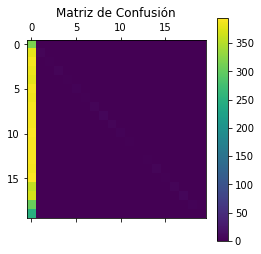

In [98]:
# Confusion Matrix
cmatrix = metrics.confusion_matrix(sub_test_output, predictions)
plt.matshow(cmatrix)
plt.colorbar()
plt.title("Matriz de Confusión")

In [99]:
# Precision
precision = metrics.precision_score(sub_test_output, predictions, average=None)
print(precision)

[0.04263045 0.75       0.33333333 0.75       0.75       1.
 1.         0.83333333 1.         1.         0.8        0.75
 0.5        1.         1.         0.75       1.         0.875
 0.8        0.25      ]


In [100]:
# Recall
recall = metrics.recall_score(sub_test_output, predictions, average=None)
print(recall)

[0.99373041 0.01542416 0.00507614 0.01530612 0.00779221 0.01012658
 0.00769231 0.01262626 0.01758794 0.01259446 0.01002506 0.00757576
 0.00254453 0.00505051 0.01269036 0.00753769 0.01648352 0.01861702
 0.01290323 0.00398406]


In [102]:
# F1 score
f1 = metrics.f1_score(sub_test_output, predictions, average=None)
print(f1)

[0.08175371 0.0302267  0.01       0.03       0.01542416 0.02005013
 0.01526718 0.02487562 0.0345679  0.02487562 0.01980198 0.015
 0.00506329 0.01005025 0.02506266 0.01492537 0.03243243 0.03645833
 0.02539683 0.00784314]


In [103]:
print(metrics.classification_report(sub_test_output, predictions))

              precision    recall  f1-score   support

           0       0.04      0.99      0.08       319
           1       0.75      0.02      0.03       389
           2       0.33      0.01      0.01       394
           3       0.75      0.02      0.03       392
           4       0.75      0.01      0.02       385
           5       1.00      0.01      0.02       395
           6       1.00      0.01      0.02       390
           7       0.83      0.01      0.02       396
           8       1.00      0.02      0.03       398
           9       1.00      0.01      0.02       397
          10       0.80      0.01      0.02       399
          11       0.75      0.01      0.02       396
          12       0.50      0.00      0.01       393
          13       1.00      0.01      0.01       396
          14       1.00      0.01      0.03       394
          15       0.75      0.01      0.01       398
          16       1.00      0.02      0.03       364
          17       0.88    